In [61]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [62]:
import pandas as pd
import numpy as np
import os

In [63]:
import os

labels = []
file_id = []

path = "../data/person_data/crop/"
full_names = sorted(os.listdir(path))

for each in full_names:
    labels.append(each.split('.')[0])
    file_id.append(each.split('.')[1])
    
unique_id = [f"{label}_{id}" for label, id in zip(labels, file_id)]

In [64]:
print(len(labels))

112


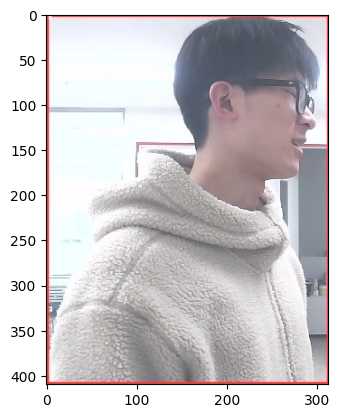

In [65]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

sample = random.choice(full_names)
image = mpimg.imread(path + sample)
plt.imshow(image)
plt.show()

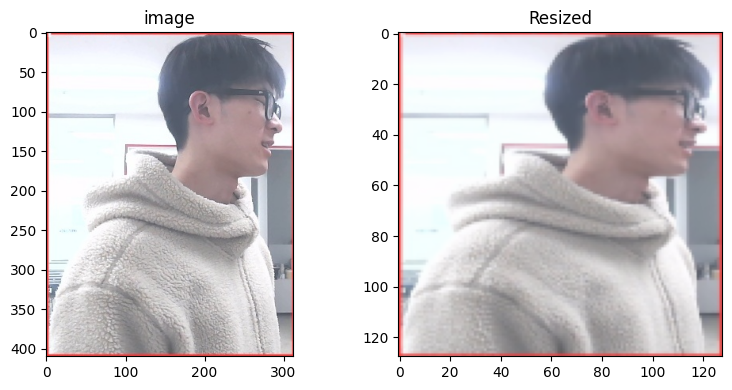

In [66]:
from skimage.transform import resize
resized = resize(image, (128, 128, 3))

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title("image")
ax[1].imshow(resized, cmap=plt.cm.gray)
ax[1].set_title("Resized")

fig.tight_layout()
plt.show()

data_generator

In [75]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

증강을 위한 라벨 처리

In [76]:
# 이미지와 라벨을 저장할 리스트 초기화
images = []
labels = []

# 이미지 디렉토리
image_dir = '/home/addinedu/project/deep-learning_project/data/person_data/crop'

# 이미지 로드
for filename in os.listdir(image_dir):
    if filename.endswith('.jpg'):
        # 이미지 로드 및 사이즈 조정
        img = load_img(os.path.join(image_dir, filename), target_size=(128, 128))
        img = img_to_array(img)
        img = img / 255.0  # 픽셀 값을 0~1 사이로 정규화
        
        images.append(img)
        
        # 파일 이름에서 라벨 추출
        label = filename.split('.')[0]
        labels.append(label)

# numpy 배열로 변환
images = np.array(images)
labels = np.array(labels)


In [114]:
datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


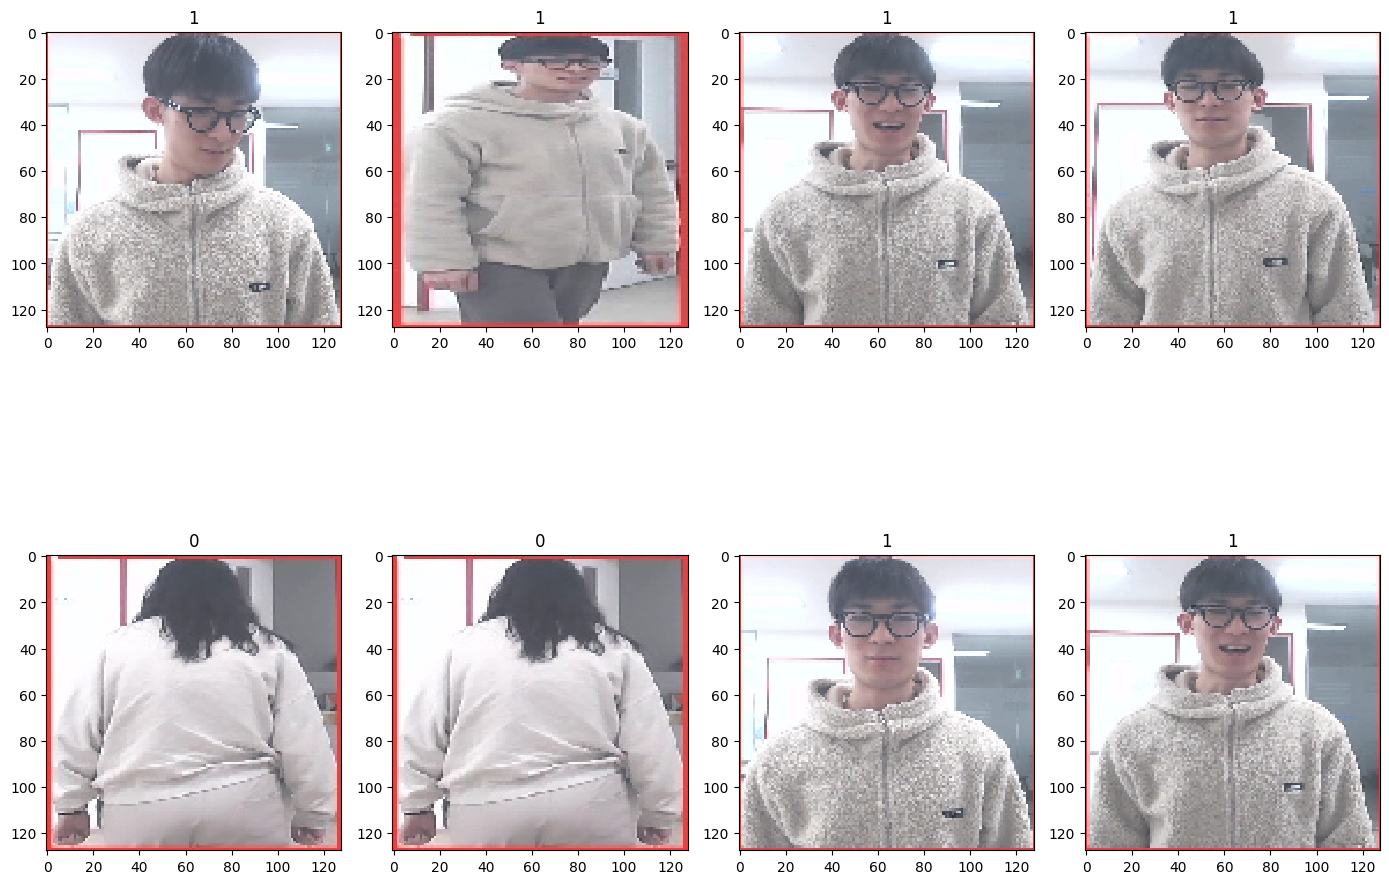

In [92]:
samples = random.choices(population=range(0, 10), k=8)

plt.figure(figsize=(14, 12))
for idx, n in enumerate(samples):
    plt.subplot(2, 4, idx+1)
    plt.imshow(X_train[n], cmap='Greys',
               interpolation='nearest')
    plt.title(y_train[n])
    
plt.tight_layout()
plt.show()

훈련 세트, 테스트 세트로 나누기

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(labels)
labels_encoded = encoder.transform(labels)
labels_encoded[:3], encoder.classes_

(array([1, 0, 0]), array(['hyegyeong', 'junyeob'], dtype='<U9'))

In [85]:
X_train, X_test, y_train, y_test =\
    train_test_split(images, labels_encoded, test_size=0.2,
                     random_state=13, stratify=labels_encoded)
    
X_train.shape, X_test.shape

((89, 128, 128, 3), (23, 128, 128, 3))

훈련 세트에만 증강 적용

In [116]:
# 데이터 증강 적용
augmented_data = datagen.flow(X_train, y_train, batch_size=32)

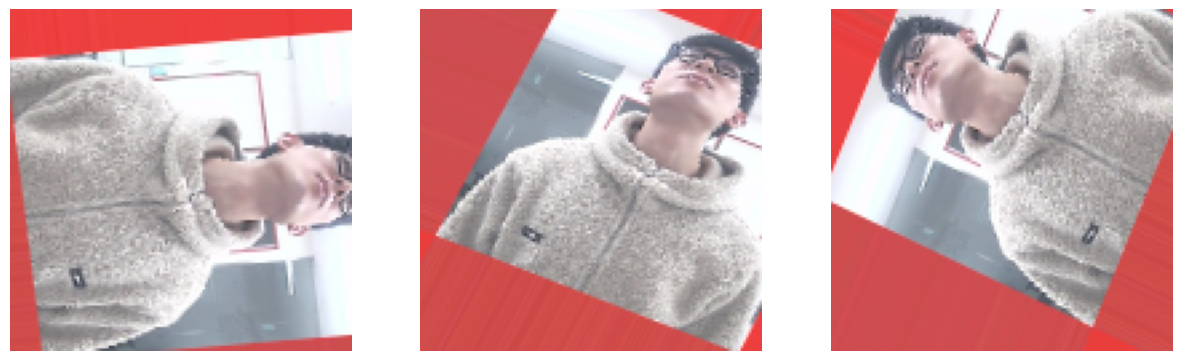

In [117]:
# 데이터 증강된 이미지를 생성할 배치 선택 (예시로 첫 번째 이미지 사용)
img_array = images[0:1]

# 데이터 증강 적용
aug_iter = datagen.flow(img_array, batch_size=1)

# 증강된 이미지를 시각화하기 위한 코드
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
for i in range(3):
    aug_img = next(aug_iter)[0]
    ax[i].imshow(aug_img)
    ax[i].axis('off')
plt.show()


### 모델 생성

In [93]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(3, activation='softmax')

])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 63, 63, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 63, 63, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 31, 31, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 31, 31, 64)       

In [94]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### 훈련 시작

In [95]:
import time

start_time = time.time()

hist = model.fit(X_train, y_train,
                 epochs=100, verbose=1,
                 validation_data = (X_test, y_test))

print('fit time : ', time.time() - start_time)

Epoch 1/100


2024-03-22 17:38:03.486253: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3/3 [==============================] - 4s 772ms/step - loss: 1.3521 - accuracy: 0.4270 - val_loss: 0.7694 - val_accuracy: 0.4783
Epoch 2/100
3/3 [==============================] - 0s 29ms/step - loss: 0.9815 - accuracy: 0.4607 - val_loss: 0.9328 - val_accuracy: 0.5217
Epoch 3/100
3/3 [==============================] - 0s 32ms/step - loss: 0.8035 - accuracy: 0.5393 - val_loss: 0.9804 - val_accuracy: 0.5217
Epoch 4/100
3/3 [==============================] - 0s 30ms/step - loss: 0.7527 - accuracy: 0.5393 - val_loss: 0.7589 - val_accuracy: 0.5217
Epoch 5/100
3/3 [==============================] - 0s 32ms/step - loss: 0.6639 - accuracy: 0.5843 - val_loss: 0.6826 - val_accuracy: 0.4783
Epoch 6/100
3/3 [==============================] - 0s 32ms/step - loss: 0.6820 - accuracy: 0.6180 - val_loss: 0.6393 - val_accuracy: 0.5217
Epoch 7/100
3/3 [==============================] - 0s 28ms/step - loss: 0.6060 - accuracy: 0.6517 - val_loss: 0.6113 - val_accuracy: 0.9130
Epoch 8/100
3/3 [==============

In [96]:
model.evaluate(X_train, y_train)

3/3 [==============================] - 0s 7ms/step - loss: 6.9171e-04 - accuracy: 1.0000


[0.0006917078862898052, 1.0]

In [97]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 20ms/step - loss: 0.0024 - accuracy: 1.0000


[0.00243474286980927, 1.0]

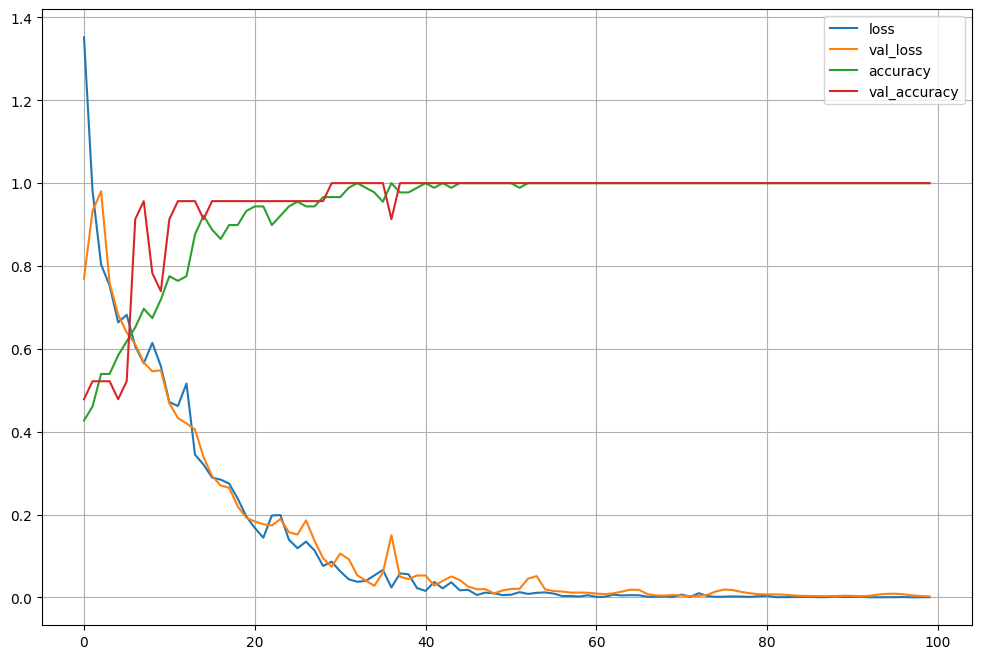

In [98]:
plot_target = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
plt.figure(figsize=(12, 8))

for each in plot_target:
    plt.plot(hist.history[each], label=each)
    
plt.legend()
plt.grid()
plt.show()

### 예측하기

In [105]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

img = load_img('../data/person_data/junyeob.20240321_173923.jpg', target_size=(128, 128))

img_array = img_to_array(img)
img_array = np.expand_dims(img_arframe_resized)
    # 최대 예측 확률과 해당 인덱스를 찾음
    predicted_prob = np.max(predictions)
    
    # 예측 결과를 사용하여 라벨링 (여기서는 간단하게 클래스 ID 출력)
    predicted_class = np.argmax(
predictions = model.predict(img_array)

predicted_class = np.argmax(predictions, axis=1)

# 클래스 인덱스와 이름을 매핑하는 딕셔너리
class_names = {0: '혜경', 1: '준엽', 2: 'Unknown'}

# 모델의 예측 결과(인덱스)
predicted_class_index = np.argmax(predictions, axis=1)[0]  # 예시로 첫 번째 예측 결과 사용

# 인덱스를 이름으로 변환
predicted_class_name = class_names[predicted_class_index]

print(f"예측된 클래스 이름: {predicted_class_name}")


1/1 [==============================] - 0s 73ms/step
예측된 클래스 이름: 혜경


128 x 128로 리사이즈

### 모델 저장

In [106]:
model.save("TEST2_Person_CNN_Model.h5")

/home/addinedu/venv/ml_venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 웹캠으로 예측하기

In [119]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# 훈련된 모델 로드
model = load_model('TEST2_Person_CNN_Model.h5')

# 웹캠 초기화
cap = cv2.VideoCapture(0)  # 0은 기본 카메라

while True:
    # 프레임 캡처
    ret, frame = cap.read()
    
    if not ret:
        break  # 프레임을 제대로 캡처하지 못한 경우
    
    # 이미지 전처리
    # 프레임 크기 조정 및 정규화 등
    frame_resized = cv2.resize(frame, (128, 128))  # 모델에 맞는 크기로 조정
    frame_resized = frame_resized.astype("float") / 255.0
    frame_resized = img_to_array(frame_resized)
    frame_resized = np.expand_dims(frame_resized, axis=0)
    
    # 모델을 사용하여 예측
    predictions = model.predict(frame_resized)
    # 최대 예측 확률과 해당 인덱스를 찾음
    predicted_prob = np.max(predictions)
    
    # 예측 결과를 사용하여 라벨링 (여기서는 간단하게 클래스 ID 출력)
    predicted_class = np.argmax(predictions, axis=1)
    
    # 클래스 인덱스와 이름을 매핑하는 딕셔너리
    class_names = {0: 'hyegyeong', 1: 'junyeob', 2: 'Unknown'}

    # 모델의 예측 결과(인덱스)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    
    # 임계값 설정 (예: 0.8)
    threshold = 0.8

    # 최대 예측 확률이 임계값 이상인지 확인
    if predicted_prob >= threshold:
        # 인덱스를 이름으로 변환
        predicted_class_name = class_names[predicted_class_index]
    else:
        predicted_class_name = class_names[2]  # Unknown

    cv2.putText(frame, "Class: {}, Prob: {:.2f}".format(predicted_class_name, predicted_prob), (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    # 결과 프레임 표시
    cv2.imshow("Frame", frame)
    
    # 'q'를 누르면 종료
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# 종료 시, 캡처 해제 및 창 닫기
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 25ms/step


#### predicted_label의 결과과 y_test(타겟) 비교해서 틀리게 예측한 값 찾기

In [73]:
import numpy as np

predicted_result = model.predict(X_test)
predicted_labels = np.argmax(predicted_result, axis=1)
predicted_labels[:10]

1/1 [==============================] - 0s 20ms/step


array([1, 1, 0, 0, 1, 1, 1, 0, 0, 0])

In [74]:
print(y_test[:10])

[1 1 0 0 1 1 1 0 0 0]
